### Import modules

In [1]:
import hashlib
import os
import pickle
from urllib.request import urlretrieve
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile
import matplotlib.pyplot as plt
import tensorflow as tf
import math

%matplotlib inline

print('All modules imported')

/home/li/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


All modules imported


### Download `notMNIST` data set

In [2]:
def download(url, file):
    if not os.path.isfile(file):
        print('Downloading {}'.format(file))
        urlretrieve(url, file)
        print('Download finished')

train_url = 'https://s3.amazonaws.com/udacity-sdc/notMNIST_train.zip'
train_file = 'notMNIST_train-1.zip'
test_url = 'https://s3.amazonaws.com/udacity-sdc/notMNIST_test.zip'
test_file = 'notMNIST_test-1.zip'

download(train_url, train_file)
download(test_url, test_file)

assert hashlib.md5(open(train_file, 'rb').read()).hexdigest() \
== 'c8673b3f28f489e9cdf3a3d74e2ac8fa', '{} is corrupted.'.format(train_file)
assert hashlib.md5(open(test_file, 'rb').read()).hexdigest() \
== '5d3c7e653e63471c88df796156a9dfa9', '{} is corrupted.'.format(test_file)

Download finished
Download finished


In [3]:
def uncompress_features_labels(file):
    """
    Uncompress features and labels from a zip file
    return np.array
    """
    features = []
    labels = []

    with ZipFile(file) as zipf:
        filenames_bar = tqdm(zipf.namelist(), unit='files')

        for filename in filenames_bar:
            if not filename.endswith('/'):
                with zipf.open(filename) as imagefile:
                    image = Image.open(imagefile)
                    image.load()
                    feature = np.array(image, dtype=np.float32).flatten()
                label = os.path.split(filename)[1][0]
                features.append(feature)
                labels.append(label)

    features = np.array(features)
    labels = np.array(labels)
    
    return features, labels

In [4]:
train_features, train_labels = uncompress_features_labels('notMNIST_train-1.zip')
test_features, test_labels = uncompress_features_labels('notMNIST_test-1.zip')
print('Train size: {}, test size: {}'.format(train_features.shape[0], test_features.shape[0]))

100%|██████████| 10001/10001 [00:00<00:00, 10641.27files/s]

Train size: 210000, test size: 10000


In [5]:
print(train_features.shape, train_labels.shape, test_features.shape, test_labels.shape)

(210000, 784) (210000,) (10000, 784) (10000,)


In [6]:
print(train_labels[0])
img = train_features[0].reshape((28, 28)).astype(np.uint8)
Image.fromarray(img)

A


Image indexes: [199340  43567 173685 117952 176963 152315  95939  97639  41993 122579]


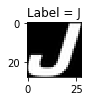

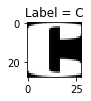

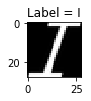

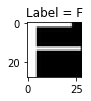

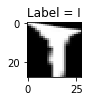

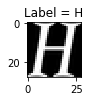

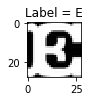

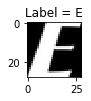

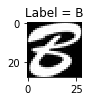

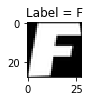

In [7]:
%matplotlib inline
np.random.seed(0)
img_idx = np.random.randint(train_features.shape[0], size=10)
print('Image indexes:', img_idx)
for n in img_idx:
    img = train_features[n].reshape((28, 28)).astype(np.uint8)
    plt.figure(figsize=(1, 1))
    plt.imshow(img, 'gray')
    plt.title('Label = {}'.format(train_labels[n]))
    plt.show()

### Normalize features

In [8]:
scaler = MinMaxScaler(feature_range=(0.1, 0.9))
train_features = scaler.fit_transform(train_features)
test_features = scaler.fit_transform(test_features)

### Binarize labels

In [9]:
lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

### Save pickle files

In [10]:
pickle_file = 'notMNIST.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump({
                'train_features': train_features, 
                'train_labels': train_labels,
                'test_features': test_features,
                'test_labels': test_labels,
                        }, pfile, pickle.HIGHEST_PROTOCOL)
    except:
        print('Unable to save data to', pickle_file, ':', e)
        raise
        
print('Data cashed in pickle file.')

Saving data to pickle file...
Data cashed in pickle file.


### Reload data from pickle file

In [11]:
pickle_file = 'notMNIST.pickle'
with open(pickle_file, 'rb') as pfile:
    pickle_data = pickle.load(pfile)
    train_features = pickle_data['train_features']
    train_labels = pickle_data['train_labels']
    test_features = pickle_data['test_features']
    test_labels = pickle_data['test_labels']
    del pickle_data
    
print('Data loaded.')

Data loaded.


### Create tensors

In [12]:
features_count = 784
labels_count = 10

features = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32)

weights = tf.Variable(tf.truncated_normal((features_count, labels_count)))
biases = tf.Variable(tf.zeros(labels_count))

biases.get_shape()

TensorShape([Dimension(10)])

In [13]:
train_features, valid_features, train_labels, valid_labels = train_test_split(train_features, 
                                                                              train_labels, 
                                                                              test_size=0.05, 
                                                                              random_state=0)

In [14]:
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

logits = tf.matmul(features, weights) + biases

prediction = tf.maximum(tf.nn.softmax(logits), 1.0e-30)

cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), axis=1)

loss = tf.reduce_mean(cross_entropy, axis=0)

init = tf.global_variables_initializer()

is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))

accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32), axis=0)


with tf.Session() as session:
    session.run(init)
    p = session.run(prediction, feed_dict=train_feed_dict)
    l = session.run(loss, feed_dict=train_feed_dict)
    d = session.run(logits, feed_dict=train_feed_dict)
    a = session.run(accuracy, feed_dict=train_feed_dict)
    idx = np.argmax(np.isnan(l)==True)
#     if idx!=0:
#         print(idx)
#         print(p[idx])
# #         print(d[idx])
#         ll = session.run(tf.log(p[idx]))
#         print(ll)
    print(p.min())
    print(a)
# 3907 is nan

1e-30
0.07978446


Epoc 20/20: 100%|██████████| 100/100 [00:00<00:00, 231.77batches/s]


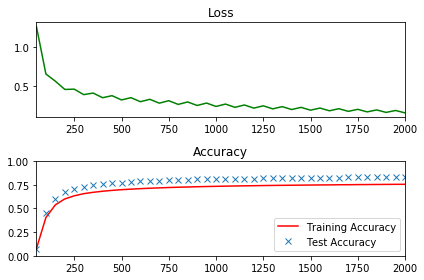

0.8305
0.9237752


In [15]:
import math

epochs = 20
batch_size = 2000
learning_rate = .1

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

test_accuracy = 0.0

log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
test_acc_batch = []

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(train_features.shape[0]/batch_size))
    
    for epoch_i in range(epochs):
        
        batches_pbar = tqdm(range(batch_count), desc='Epoc {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        for batch_i in batches_pbar:
            batch_start = batch_i * batch_size
            batch_features = train_features[batch_start:(batch_start + batch_size)]
            batch_labels = train_labels[batch_start:(batch_start + batch_size)]
            
            session.run(optimizer, feed_dict={features: batch_features, labels: batch_labels})
            l = session.run(loss, feed_dict={features: batch_features, labels: batch_labels})
            
            if not batch_i % log_batch_step:
                train_acc = session.run(accuracy, feed_dict=train_feed_dict)
                test_acc = session.run(accuracy, feed_dict=test_feed_dict)
                
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(train_acc)
                test_acc_batch.append(test_acc)
                
    test_acc = session.run(accuracy, feed_dict=test_feed_dict)
    test_loss = session.run(loss, feed_dict=test_feed_dict)
        
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, np.log10(loss_batch), 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, test_acc_batch, 'x', label='Test Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc='lower right')
plt.tight_layout()
plt.show()
print(test_acc)
print(test_loss)

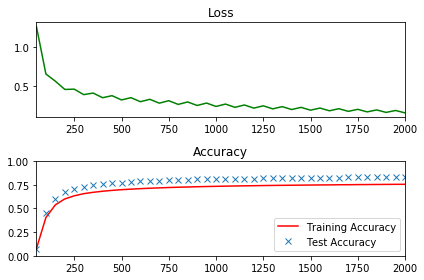

0.8305
0.9237752


In [16]:
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, np.log10(loss_batch), 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, test_acc_batch, 'x', label='Test Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc='lower right')
plt.tight_layout()
plt.show()
print(test_acc)
print(test_loss)